<h1 style='text-align: center'>Postal Codes of Canada : M</h1>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium

from sklearn.cluster import KMeans

import requests
from bs4 import BeautifulSoup

In [2]:
from utils.nearby_venues import getNearbyVenues

## 1. Get Data from Wikipedia

##### Request the URL, extract the text from it, and transform it to a BeautifulSoup object

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
txt = requests.get(url).text
soup = BeautifulSoup(txt)

##### Find the &lt;table&gt; tag and from it, extract all &lt;table&gt;s

In [4]:
tds = soup.find('table').find_all('td')

##### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [5]:
tds = [td for td in tds if not 'Not assigned' in td.text]

##### The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [6]:
postalcode = [td.find('b').text for td in tds]
boroughs = [td.find('span').text for td in tds]

In [7]:
df = pd.DataFrame(
    {'PostalCode': postalcode,
     'Borough': boroughs}
)

##### Boroughs and Neighborhoods are mixed. But we can extract them by splitting with '('

In [8]:
temp = df['Borough'].str.split('(', expand=True)[[0, 1]]
df[['Borough', 'Neighborhood']] = temp[[0, 1]]

In [9]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods)
1,M4A,North York,Victoria Village)
2,M5A,Downtown Toronto,Regent Park / Harbourfront)
3,M6A,North York,Lawrence Manor / Lawrence Heights)
4,M7A,Queen's Park / Ontario Provincial Government,None


##### Neighborhoods are separated with a comma

In [10]:
df['Neighborhood'] = df['Neighborhood'].str.replace(' / ', ', ')

##### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [11]:
df['Neighborhood'] = df['Neighborhood'].fillna(df['Borough'])

In [12]:
condition = df['Neighborhood'].str.endswith(')')
df.loc[condition, 'Neighborhood'] = df.loc[condition, 'Neighborhood'].str[:-1]

In [13]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government


In [14]:
df.set_index('PostalCode').loc['M5A']

Borough                  Downtown Toronto
Neighborhood    Regent Park, Harbourfront
Name: M5A, dtype: object

In [15]:
df.shape

(103, 3)

## 2. Adding geolocation

##### Reading the geolocation data from web

In [16]:
geoloc = pd.read_csv(
    'http://cocl.us/Geospatial_data',
    names=['PostalCode', 'latitude', 'longitude'],
    header=0
)

In [17]:
geoloc.head()

,PostalCode,latitude,longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Merging the geolocation dataset with our postal codes dataframe

In [18]:
df = pd.merge(df, geoloc, on='PostalCode', how='left')

In [19]:
df.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [20]:
print(df.latitude.isnull().mean())
print(df.longitude.isnull().mean())

0.0
0.0


##### Define the centroid location's latitude and longitude for the map

In [21]:
c_latitude, c_longitude = df.latitude.mean(), df.longitude.mean()

## 3. Exploring neighborhoods

##### Create a map of Toronto with neighborhoods superimposed on top.

In [23]:
map_newyork = folium.Map(location=[c_latitude, c_longitude], zoom_start=10)
zipped = zip(df['latitude'], df['longitude'], df['Borough'], df['Neighborhood'])

for lat, lng, borough, neighborhood in zipped:
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True, fill_color='#3186cc', fill_opacity=0.7,
        parse_html=False
    ).add_to(map_newyork)  
    
map_newyork

<img src="img/capture1.png"/>

##### Let's call the function defined in the Course and apply it to all the neighborhoods in Toronto. 

In [24]:
toronto_venues = getNearbyVenues(
    names=df['Neighborhood'],
    latitudes=df['latitude'],
    longitudes=df['longitude']
)

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(2247, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Family
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,parks_outdoors
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,shops
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,arts_entertainment
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,food
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,food


In [26]:
nb_venues_per_neighborhood = toronto_venues['Neighborhood'].value_counts()

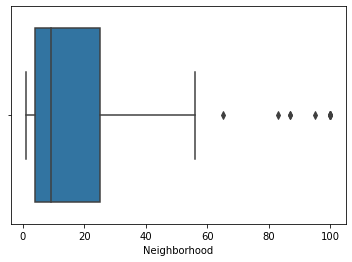

In [27]:
sns.boxplot(nb_venues_per_neighborhood)

In [28]:
toronto_venues['Venue Family'].value_counts()

food                  1256
shops                  464
nightlife              149
parks_outdoors         117
arts_entertainment      93
travel                  88
building                77
education                3
Name: Venue Family, dtype: int64

In [29]:
toronto_venues.groupby('Venue Family')['Venue Category'].apply(set)

Venue Family
arts_entertainment    {Concert Hall, Theater, Performing Arts Venue,...
building              {Coworking Space, Event Space, Gym / Fitness C...
education              {College Rec Center, Supplement Shop, Cafeteria}
food                  {Dumpling Restaurant, Japanese Restaurant, Pou...
nightlife             {Lounge, Speakeasy, Sake Bar, Gay Bar, Irish P...
parks_outdoors        {Lake, Sculpture Garden, Outdoor Sculpture, Tr...
shops                 {Gas Station, Record Shop, Toy / Game Store, W...
travel                {Airport Food Court, Roof Deck, Bed & Breakfas...
Name: Venue Category, dtype: object

In [30]:
# one hot encoding
toronto_onehot = pd.concat(
    [
        toronto_venues['Neighborhood'],
        pd.get_dummies(toronto_venues[['Venue Family']], prefix="", prefix_sep="")
    ],
    axis=1
)
print(toronto_onehot.shape)
toronto_onehot.head()

(2247, 9)


,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,Parkwoods,0,0,0,0,0,1,0,0
1,Parkwoods,0,0,0,0,0,0,1,0
2,Victoria Village,1,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,1,0,0,0,0
4,Victoria Village,0,0,0,1,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean()
toronto_grouped.head()

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
Neighborhood,,,,,,,,
Agincourt),0.0,0.000000,0.0,0.400000,0.200000,0.200000,0.200000,0.0
"Alderwood, Long Branch",0.0,0.111111,0.0,0.444444,0.111111,0.222222,0.111111,0.0
"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.0,0.523810,0.000000,0.047619,0.428571,0.0
Bayview Village,0.0,0.000000,0.0,0.750000,0.000000,0.000000,0.250000,0.0
"Bedford Park, Lawrence Manor East",0.0,0.000000,0.0,0.769231,0.038462,0.000000,0.192308,0.0


In [100]:
for neighbor in toronto_grouped.sample(3).index.tolist():
    print('-'*10 + neighbor + '-'*10)
    print(toronto_grouped.loc[neighbor].sort_values(ascending=False).head(5))
    print('\n')

----------Guildwood, Morningside, West Hill----------
shops             0.500
food              0.250
travel            0.125
building          0.125
parks_outdoors    0.000
Name: Guildwood, Morningside, West Hill, dtype: float64


----------Scarborough Village----------
parks_outdoors    0.5
building          0.5
travel            0.0
shops             0.0
nightlife         0.0
Name: Scarborough Village, dtype: float64


----------Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West----------
shops        0.400000
food         0.400000
building     0.133333
education    0.066667
travel       0.000000
Name: Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, dtype: float64




## 4. Cluster Neighborhoods

##### Let's find the optimal number of clusters using the Elbow method

In [101]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped)
    sum_of_squared_distances.append(km.inertia_)

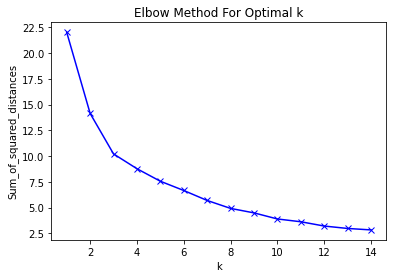

In [102]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [103]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(
    n_clusters=kclusters, 
    random_state=0,
    init='k-means++',
).fit(toronto_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 3, 1, 0, 0, 2, 2, 3, 2, 0, 0, 2, 3, 2, 2, 3, 0, 2, 2, 1, 2,
       3, 1, 2, 0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 2, 3, 0, 0, 3, 2, 2, 3,
       2, 2, 2, 1, 1, 3, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1, 0, 2,
       2, 2, 2, 3, 2, 2, 0, 2, 3, 0, 3])

In [104]:
# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [105]:
df['Cluster Labels'] = 'Cluster ' + df['Neighborhood'].map(
    toronto_grouped['Cluster Labels'].astype(int).astype(str).to_dict()
).fillna('NC')

In [106]:
df.head(2)

,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,Cluster 3
1,M4A,North York,Victoria Village,43.725882,-79.315572,Cluster 2


In [107]:
toronto_venues.head(2)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Family
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,parks_outdoors
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,shops


In [109]:
temp = toronto_grouped.groupby('Cluster Labels').mean().mul(100)

In [112]:
temp

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
Cluster Labels,,,,,,,,
0,0.170940,2.857982,0.370370,27.319893,2.881403,4.235892,59.702317,2.461201
1,5.000000,5.000000,0.000000,5.000000,0.000000,76.666667,0.000000,8.333333
2,3.104533,3.017767,0.018868,61.665655,5.885203,4.263918,17.558048,4.486007
3,5.185185,2.954145,5.555556,16.987835,4.440236,30.626704,25.320467,8.929874


In [110]:
import plotly.graph_objects as go
clusters = temp.index.tolist()
bars = [
    go.Bar(name=i, x=clusters, y=temp[i].tolist())
    for i in temp.columns
]
fig = go.Figure(data=bars)
fig.update_layout(barmode='stack')
fig.show()

From this graph we can understand the composition of the clusters:

The first cluster has a lot of shops

The second cluster has a large amount of parks

The third one is when you are really hungry

The fourth one is the most balanced one, with some level of food, shops, nightlife, arts, entertainment, and parks.

In [111]:
# create map
K = df['Cluster Labels'].unique()
map_clusters = folium.Map(location=[c_latitude, c_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(len(K))
colors = {
    'Cluster 0': 'green',
    'Cluster 1': 'yellow',
    'Cluster 2': 'red',
    'Cluster 3': 'blue',
    'Cluster NC': 'black',
}
# add markers to the map
markers_colors = []
zipped = zip(df['latitude'], df['longitude'], df['Neighborhood'], df['Cluster Labels'])
for lat, lon, poi, cluster in zipped:
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<img src="img/capture2.png"/>